#  Fastball Factor Analysis
## Preprocessing

In [1]:
# Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data
df_train = pd.read_csv('training.csv')
df_test = pd.read_csv('deploy.csv')

In [3]:
# Show the data
df_train.head()

,InPlay,Velo,SpinRate,HorzBreak,InducedVertBreak
0,0,95.33,2893.0,10.68,21.33
1,0,94.41,2038.0,17.13,5.77
2,0,90.48,2183.0,6.61,15.39
3,0,93.04,2279.0,9.33,14.57
4,0,95.17,2384.0,6.99,17.62


In [4]:
df_test.head()

,Velo,SpinRate,HorzBreak,InducedVertBreak
0,94.72,2375.0,3.10,18.15
1,95.25,2033.0,11.26,14.50
2,92.61,2389.0,11.00,21.93
3,94.94,2360.0,6.84,18.11
4,97.42,2214.0,16.70,13.38


In [5]:
# Check the data integrity
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   InPlay            10000 non-null  int64  
 1   Velo              10000 non-null  float64
 2   SpinRate          9994 non-null   float64
 3   HorzBreak         10000 non-null  float64
 4   InducedVertBreak  10000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 390.8 KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Velo              10000 non-null  float64
 1   SpinRate          9987 non-null   float64
 2   HorzBreak         10000 non-null  float64
 3   InducedVertBreak  10000 non-null  float64
dtypes: float64(4)
memory usage: 312.6 KB


In [7]:
# Impute the missing values with KNN
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_train = pd.DataFrame(imputer.fit_transform(df_train),columns = df_train.columns)
df_test = pd.DataFrame(imputer.fit_transform(df_test),columns = df_test.columns)

* The SpinRate in some dataframe is missing, therefore, we may need to drop those data. The altnative approach is to impute.
* Using KNN imputer, we can keep the data integriy by filling those missing with the most close group average

## Modeling
### Base Model - Logistic Regression

* StandardScaler is used to ensure the factor with larger numerical value will not dominate the result(for some scale-sensitive models)

In [8]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df_train.drop('InPlay',axis=1), df_train['InPlay'],
                                                    test_size=0.2, random_state=42)
# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Create the model
logmodel = LogisticRegression()

# Fit the model
logmodel.fit(X_train,y_train)

# Predict the model
y_pred = logmodel.predict(X_test)

# Check the accuracy
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

# Show the confusion matrix
confusion_matrix(y_test, y_pred)

Accuracy: 0.732
F1 score: 0.003717472118959108


array([[1463,    0],
       [ 536,    1]])

* Only 1 is classifed as 'in play'

In [9]:
# Check the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.73      1.00      0.85      1463
         1.0       1.00      0.00      0.00       537

    accuracy                           0.73      2000
   macro avg       0.87      0.50      0.42      2000
weighted avg       0.80      0.73      0.62      2000



* The overall result of 'InPlay' is bad from the base, since the model is sacrificing the predicton in play rate to increase the model performance
* The accuracy is biased in this case, we should considering f1 score (weighted) as the metric

### Weighted Logistic Regression

In [10]:
# Train with logistic regression on weighted method
logmodel = LogisticRegression(class_weight='balanced')

# Fit the model
logmodel.fit(X_train, y_train)

# Predict the model
y_pred = logmodel.predict(X_test)

# Check the accuracy
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

# Show the confusion matrix
confusion_matrix(y_test, y_pred)

Accuracy: 0.5955
F1 score: 0.40470934510669604


array([[916, 547],
       [262, 275]])

In [11]:
# Check the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.63      0.69      1463
         1.0       0.33      0.51      0.40       537

    accuracy                           0.60      2000
   macro avg       0.56      0.57      0.55      2000
weighted avg       0.66      0.60      0.62      2000



* Using the weighted method, the model performance drop by 15%, but making the prediction on the 'InPlay'=1 result. And we can see the f1-score is improved

**Balance Attempt**

### Before Data Balance - SMOTE

In [12]:
# Model libarary
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA

In [13]:
# Making the modeling process into a function
def model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred), model

In [14]:
# List of classifiers
classifiers = [
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("Gaussian Naive Bayes", GaussianNB()),
    ("AdaBoost", AdaBoostClassifier()),
    ("MLP (Neural Network)", MLPClassifier(hidden_layer_sizes=(100,))),
    ("Linear Discriminant Analysis", LinearDiscriminantAnalysis()),
    ("Quadratic Discriminant Analysis", QuadraticDiscriminantAnalysis()),
    ("SGD Classifier", SGDClassifier()),
    ("Extra Trees Classifier", ExtraTreesClassifier())
]

# Automating the modeling process for each classifier
for name, clf in classifiers:
    score, _ = model(X_train, y_train, X_test, y_test, clf)
    print(f"[F1] {name} :", score)

[F1] Gradient Boosting : 0.007380073800738008
[F1] Gaussian Naive Bayes : 0.07432432432432431
[F1] AdaBoost : 0.018214936247723135
[F1] MLP (Neural Network) : 0.003717472118959108
[F1] Linear Discriminant Analysis : 0.003717472118959108
[F1] Quadratic Discriminant Analysis : 0.014652014652014652
[F1] SGD Classifier : 0.0
[F1] Extra Trees Classifier : 0.1566265060240964


* It is a common situation for ML model avoiding the prediction in 'in play' situation to increase the overall performance

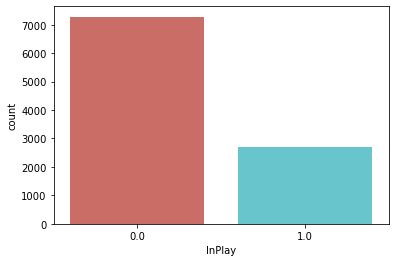

In [15]:
# Show the distribution of the 'InPlay' variable
sns.countplot(x='InPlay',data=df_train, palette='hls')
plt.show()

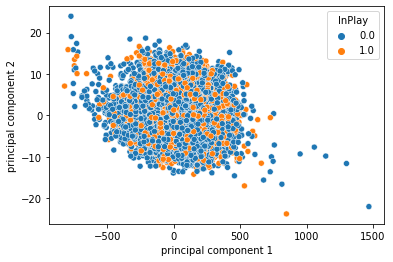

In [16]:
# PCA  (Principal Component Analysis)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_train.drop('InPlay',axis=1))
principalDf = pd.DataFrame(data = principalComponents
                , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_train[['InPlay']]], axis = 1)

# Plot the PCA
sns.scatterplot(x='principal component 1', y='principal component 2', hue='InPlay', data=finalDf)
plt.show()

* Here we can observe how the data is imbalanced with more observation are considered as 'not in play'
* The PCA also shows the 'in play' ball are quite similar based on the given features

### After Balance

In [17]:
# Use SMOTE to oversample the minority class
from imblearn.over_sampling import SMOTE

# List of classifiers
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

In [18]:
# Set the oversampler
os = SMOTE(random_state=0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df_train.drop('InPlay',axis=1), df_train['InPlay'], test_size=0.2, random_state=42)
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))

# Oversample the minority class
X_train, y_train = os.fit_resample(X_train, y_train)
print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


# List of classifiers
classifiers = [
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("Gaussian Naive Bayes", GaussianNB()),
    ("AdaBoost", AdaBoostClassifier()),
    ("MLP (Neural Network)", MLPClassifier(hidden_layer_sizes=(100,))),
    ("Linear Discriminant Analysis", LinearDiscriminantAnalysis()),
    ("Quadratic Discriminant Analysis", QuadraticDiscriminantAnalysis()),
    ("SGD Classifier", SGDClassifier()),
    ("Extra Trees Classifier", ExtraTreesClassifier()),
    ("Logistic Regression", LogisticRegression(class_weight='balanced')),
    ("Random Forest", RandomForestClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Support Vector Classifier", SVC(probability=True)), # Probability=True to ensure it can compute probabilities
    ("Bagging Classifier with KNN", BaggingClassifier(KNeighborsClassifier())),
    ("Ridge Classifier", RidgeClassifier()),
    ("Passive Aggressive Classifier", PassiveAggressiveClassifier()),
    ("Perceptron", Perceptron()),
    ("Bernoulli Naive Bayes", BernoulliNB())
]


# Automating the modeling process for each classifier
model_scores = {}
model_list = []
for name, clf in classifiers:
    score, _ = model(X_train, y_train, X_test, y_test, clf)
    model_scores[name] = score.mean()
    model_list.append((name, clf))
    print(f"[F1] {name} :", score)

Before OverSampling, counts of label '1': 2180
After OverSampling, counts of label '1': 5820
[F1] Gradient Boosting : 0.4210526315789474
[F1] Gaussian Naive Bayes : 0.4110671936758894
[F1] AdaBoost : 0.4142857142857143
[F1] MLP (Neural Network) : 0.3915900131406045
[F1] Linear Discriminant Analysis : 0.41350210970464135
[F1] Quadratic Discriminant Analysis : 0.4153846153846154
[F1] SGD Classifier : 0.4176334106728538
[F1] Extra Trees Classifier : 0.3145299145299145
[F1] Logistic Regression : 0.4146170063246662
[F1] Random Forest : 0.31423895253682493
[F1] Decision Tree : 0.3456614509246088
[F1] K-Nearest Neighbors : 0.35416666666666674
[F1] Support Vector Classifier : 0.41312741312741313
[F1] Bagging Classifier with KNN : 0.36300417246175243
[F1] Ridge Classifier : 0.41350210970464135
[F1] Passive Aggressive Classifier : 0.359275575134606
[F1] Perceptron : 0.4197080291970803
[F1] Bernoulli Naive Bayes : 0.4041095890410959


In [19]:
# Pick the top 5 classifiers
model_score_top5 = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)[:5]

In [20]:
model_score_top5

[('Gradient Boosting', 0.4210526315789474),
 ('Perceptron', 0.4197080291970803),
 ('SGD Classifier', 0.4176334106728538),
 ('Quadratic Discriminant Analysis', 0.4153846153846154),
 ('Logistic Regression', 0.4146170063246662)]

* The gradient boosting classifer has the more accuarate and balanced output

### Soft Voting Method

In [21]:
# Model library
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [22]:
# Create a voting classifier with the top 5 classifiers
voting_clf = VotingClassifier(estimators=[
                            ('lr', LogisticRegression()),
                            ('rf', RandomForestClassifier()),
                            ('gnb', GaussianNB())], voting='soft')

# Train and evaluate the voting classifier
voting_clf.fit(X_train,y_train)
y_pred = voting_clf.predict(X_test)
print(f1_score(y_test, y_pred))

0.3640383198231393


In [23]:
# Define individual classifiers
clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
clf4 = SVC(probability=True)  # Need to set probability=True for soft voting
clf5 = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1, random_state=1)
clf6 = KNeighborsClassifier(n_neighbors=7)

# Create a list of tuples where each tuple is a pair of name, classifier
model_list = [
    ('lr', clf1),
    ('rf', clf2),
    ('gnb', clf3),
    ('svc', clf4),
    ('gbc', clf5),
    ('knn', clf6)
]

# Create a list of soft voting classifiers using various combinations
soft_voting_classifiers = [
    ('Soft Voting 1', VotingClassifier(estimators=[model_list[0], model_list[1], model_list[2]], voting='soft')),
    ('Soft Voting 2', VotingClassifier(estimators=[model_list[3], model_list[4], model_list[5]], voting='soft')),
    ('Soft Voting 3', VotingClassifier(estimators=[model_list[0], model_list[3], model_list[5]], voting='soft')),
    ('Soft Voting 4', VotingClassifier(estimators=[model_list[1], model_list[3], model_list[4]], voting='soft')),
    ('Soft Voting 5', VotingClassifier(estimators=[model_list[2], model_list[4], model_list[5]], voting='soft')),
]

# Train and evaluate the soft voting classifiers
sf_scores = {}
for svc in soft_voting_classifiers:
    svc[1].fit(X_train, y_train)
    y_pred = svc[1].predict(X_test)
    sf_scores[svc[0]] = f1_score(y_test, y_pred)

In [24]:
sf_scores

{'Soft Voting 1': 0.3810229799851742,
 'Soft Voting 2': 0.3945578231292517,
 'Soft Voting 3': 0.3920493488690884,
 'Soft Voting 4': 0.380952380952381,
 'Soft Voting 5': 0.3882030178326475}

* The voting method are not outperfoming the GB or even weighted LR, so we will not considering this approach

## Best Model

In [25]:
# Create the model
gb = GradientBoostingClassifier()

# Fit the model
gb.fit(X_train, y_train)

# Predict the model
y_pred = gb.predict(X_test)

# Check the accuracy
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

# Check the classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.549
F1 score: 0.4210526315789474
              precision    recall  f1-score   support

         0.0       0.79      0.53      0.63      1463
         1.0       0.32      0.61      0.42       537

    accuracy                           0.55      2000
   macro avg       0.55      0.57      0.53      2000
weighted avg       0.66      0.55      0.57      2000



In [26]:
# Show the confusion matrix
confusion_matrix(y_test, y_pred)

array([[770, 693],
       [209, 328]])

In [30]:
# predict the test data
final_pred = gb.predict(df_test)

# Save the prediction to a csv file
pd.DataFrame(final_pred).to_csv("deploy_pred.csv")

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


In [31]:
# Soft prediction
final_pred_soft = gb.predict_proba(df_test)

# Save the prediction to a csv file
pd.DataFrame(final_pred_soft).to_csv("deploy_proba.csv")

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


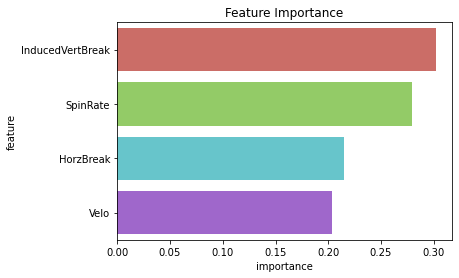

In [29]:
# Show the feature importance
feature_importance = pd.DataFrame({'feature': df_train.drop('InPlay',axis=1).columns, 'importance': gb.feature_importances_})
feature_importance.sort_values(by='importance', ascending=False)

# Plot the feature importance
sns.barplot(x='importance', y='feature', data=feature_importance.sort_values(by='importance', ascending=False), palette='hls')
plt.title('Feature Importance')
plt.show()

In [32]:
feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
3,InducedVertBreak,0.302113
1,SpinRate,0.279695
2,HorzBreak,0.215023
0,Velo,0.203169
